In [47]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors
from scipy.stats.mstats import winsorize
import seaborn as sns
import numpy as np
from ipywidgets import widgets
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'


In [48]:
gdf = gpd.read_file('../../input/shapes/BA/29MUE250GC_SIR.shp')
all_nighttime_lights = pd.read_csv('../../model/coordinates_with_distances.csv')
pib_ba = pd.read_csv('../../model/pib_ba.csv')
income_ba = pd.read_csv('../../model/income_avg_ba.csv')
all_nighttime_lights

,lat,long,radiance,city,city_code,dist_to_city
0,-8.533333,-39.383333,0.116815,CURAÇÁ,2909901,0.694998
1,-8.533333,-39.379167,0.103567,CURAÇÁ,2909901,0.698149
2,-8.537500,-39.395833,0.880825,CURAÇÁ,2909901,0.682846
3,-8.537500,-39.391667,0.184479,CURAÇÁ,2909901,0.685978
4,-8.537500,-39.387500,0.136107,CURAÇÁ,2909901,0.689120
...,...,...,...,...,...,...
2706401,-17.995833,-39.637500,0.024543,NOVA VIÇOSA,2923001,0.284567
2706402,-17.995833,-39.633333,0.013221,NOVA VIÇOSA,2923001,0.280684
2706403,-17.995833,-39.491667,0.020918,NOVA VIÇOSA,2923001,0.157517
2706404,-18.000000,-39.641667,0.041632,NOVA VIÇOSA,2923001,0.289964


# RADIANCE MAP

Com o objetvio de visualizar a intensidade de luz noturna na Bahia, foi criado um mapa mostrando como cada cidade do estado gerou luminosidade noturna durante o ano de 2010.

### DISTRIBUTION

<AxesSubplot: >

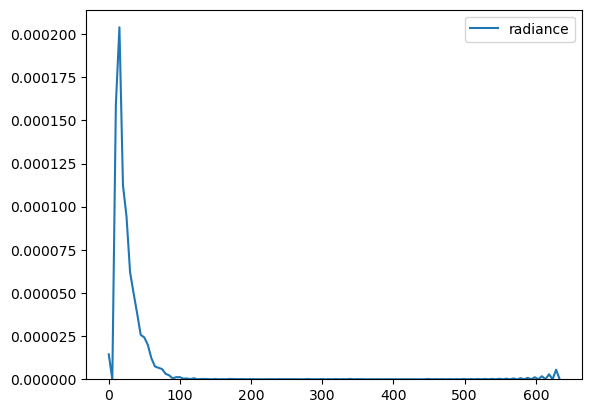

In [49]:
sns.kdeplot(all_nighttime_lights['radiance'])

### WINSORIZATION - DETECT OUTLIERS

Como visto na distribuição, temos que lidar com os outliers a fim de ter uma melhor visualização das informações.
A técnica escolhida foi a Winsorization.
Nesta técnica, nos definimos uma porcentagem dos nossos dados que serão transformados em dados mais próximos dos demais do conjunto.

![SNOWFALL](./winsorize.png)
![SNOWFALL](./winsorize_example.png)

In [50]:
all_nighttime_lights = all_nighttime_lights[all_nighttime_lights['radiance'] > 0]
all_nighttime_lights['w_radiance'] = winsorize(all_nighttime_lights['radiance'],(0,0.001))
all_nighttime_lights.sort_values('radiance', ascending=False).head(10)


,lat,long,radiance,city,city_code,dist_to_city,w_radiance
1623447,-12.712500,-38.570833,633.52026,SÃO FRANCISCO DO CONDE,2929206,0.133517,39.03453
2234237,-14.112500,-41.858333,495.54465,BRUMADO,2904605,0.212648,39.03453
2234238,-14.112500,-41.854167,495.52524,BRUMADO,2904605,0.208909,39.03453
1580567,-12.654167,-38.325000,451.18010,CAMAÇARI,2905701,0.044656,39.03453
1580568,-12.654167,-38.320833,446.55084,CAMAÇARI,2905701,0.044919,39.03453
1623480,-12.716667,-38.570833,393.26886,SÃO FRANCISCO DO CONDE,2929206,0.136131,39.03453
1623446,-12.712500,-38.575000,352.55860,SÃO FRANCISCO DO CONDE,2929206,0.130267,39.03453
652145,-10.366667,-38.795833,352.37600,EUCLIDES DA CUNHA,2910701,0.258976,39.03453
652144,-10.366667,-38.800000,340.13202,EUCLIDES DA CUNHA,2910701,0.255471,39.03453
652262,-10.370833,-38.795833,340.12555,EUCLIDES DA CUNHA,2910701,0.256761,39.03453


### CONVERT LAT AND LONG TO GEO POINTS

In [51]:
all_gdf_points = gpd.GeoDataFrame(
      all_nighttime_lights, geometry=gpd.points_from_xy(all_nighttime_lights.long, all_nighttime_lights.lat))
all_gdf_points.sort_values(by='w_radiance', ascending=True, inplace=True)

### PLOT RADIANCE MAP

In [52]:
newcmp = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#222220", "white"])

cities = all_gdf_points["city"].sort_values().unique().tolist()
text = 'Cidade: '
dropdown = widgets.Dropdown(
    options= ["All"] + cities,
    value="All",
    description="City",
    disabled=False
)

ui = widgets.HBox([dropdown])

def select_city(item):
    done = False
    if item == 'All':
      points = all_gdf_points
      shape = gdf
    else:
      points = all_gdf_points[all_gdf_points['city'] == item]
      city_code = points.iloc[0]['city_code']
      shape = gdf[gdf['CD_GEOCMU'] == str(city_code)]

    fig, ax = plt.subplots(figsize=(10,10))
    
    shape_plot = shape.plot(color="#222220", ax=ax, edgecolor="grey", linewidth=0.4)
    points_plot = points.plot(
      column='w_radiance', 
      ax=ax,
      cmap=newcmp,
      markersize=2
    )

    ax.axis('off')
    vmin = all_gdf_points['w_radiance'].min()
    vmax = all_gdf_points['w_radiance'].max()
    fig.patch.set_facecolor('#151513')

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=newcmp, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, ax=plt.gca())    

out = widgets.interactive_output(select_city, {'item': dropdown})
display(ui, out)

Output()

# CENSUS DATA

Um segundo ponto importante para estudo, é entender a correlação da intensidade de luz noturna com os indicadores socioeconômicos.

### DISTRIBUTION - CORRELATION

#### AVG RADIANCE AND MERGES

Como temos diversos pontos para cada cidade, aqui é agrupado todos eles por cidade e feito uma média da luminosidade noturna.

In [53]:
all_nighttime_lights.groupby(by='city_code')['city_code'].size().mean()

4520.513189448441

In [54]:
avg_radiance = all_nighttime_lights.groupby(by='city_code')['radiance'].mean().reset_index()
data = avg_radiance.merge(pib_ba, on='city_code', how='inner')
data = data.merge(income_ba, on='city_code', how='inner')
data.sort_values(by='pib')

,city_code,radiance,pib,population,pib_per_capta,income,city,state
121,2910206,0.638764,17237.0,3884,4.438,374.71,Dom Macedo Costa,BA
152,2912608,0.044929,18134.0,4870,3.724,229.61,Ibiquera,BA
222,2918704,0.081202,19609.0,3865,5.073,327.79,Lafaiete Coutinho,BA
136,2911253,0.083652,20035.0,4535,4.418,309.01,Gavião,BA
159,2913309,0.313053,20484.0,5269,3.888,345.94,Ichu,BA
...,...,...,...,...,...,...,...,...
230,2919207,26.854139,3652178.0,167309,21.829,1169.18,Lauro de Freitas,BA
356,2929206,6.068192,5323914.0,33713,157.919,501.57,São Francisco do Conde,BA
130,2910800,3.100447,7179906.0,562466,12.765,761.42,Feira de Santana,BA
70,2905701,5.738963,12446027.0,249206,49.943,632.27,Camaçari,BA


#### DISTRIBUTION

<AxesSubplot: >

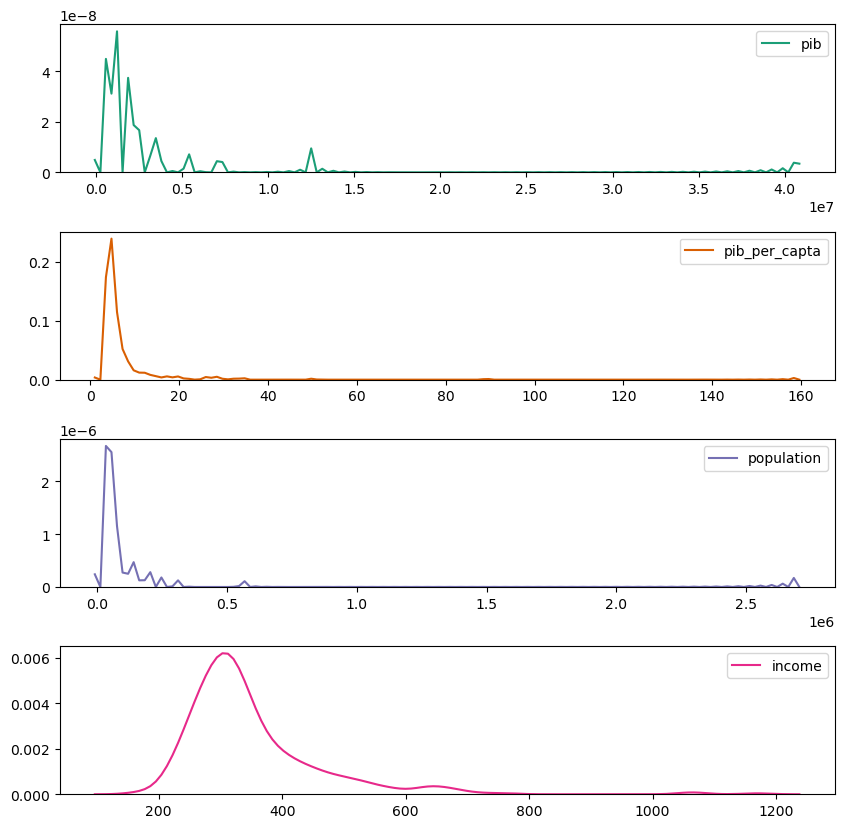

In [55]:
fig, axs = plt.subplots(nrows=4, figsize=(10,10))
plt.subplots_adjust(hspace=0.4)


sns.kdeplot(data['pib'], ax=axs[0], color="#1b9e77")
sns.kdeplot(data['pib_per_capta'], ax=axs[1], color="#d95f02")
sns.kdeplot(data['population'], ax=axs[2], color="#7570b3")
sns.kdeplot(data['income'], ax=axs[3], color="#e7298a")
# 40 000 000

#### CORRELATION
A primeira forma para analisar a correlação foi utilizando gráficos de disperção. Mas para isso, primeiro foi necessário lidar com os outliers de forma diferente de como foi feito anteriormente.
Desta vez, foi utilizado o Z-score, para removermos todos os dados superiores/inferiores a 3 desvios padrões, para assim facilitar a visualização do grafico.

<AxesSubplot: xlabel='radiance', ylabel='income'>

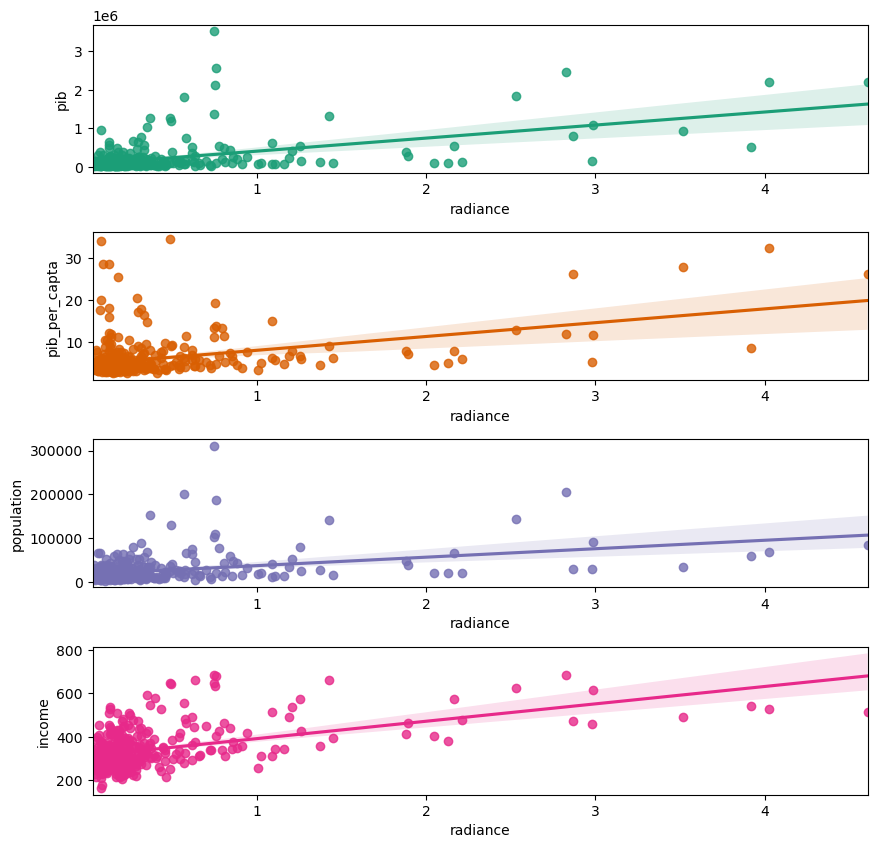

In [56]:
# REMOVE OUTLIERS (Z-SCORE)
threshold = 3
outlier_pib = []
outlier_income = []
outlier_radiance = []
for i, row in data.iterrows():
    z_pib = (row['pib_per_capta'] - np.mean(data['pib_per_capta'])) / np.std(data['pib_per_capta'])
    z_income = (row['income'] - np.mean(data['income'])) / np.std(data['income'])
    z_radiance = (row['radiance'] - np.mean(data['radiance'])) / np.std(data['radiance'])
    if z_pib > threshold:
        outlier_pib.append(row['pib_per_capta'])
    if z_income > threshold:
        outlier_income.append(row['income'])
    if z_radiance > threshold:
        outlier_radiance.append(row['radiance'])
newdata = data[(~data['pib_per_capta'].isin(outlier_pib)) & (~data['income'].isin(outlier_income)) & (~data['radiance'].isin(outlier_radiance))]
newdata
fig, axs = plt.subplots(nrows=4, figsize=(10,10))
plt.subplots_adjust(hspace=0.4)

sns.regplot(x=newdata["radiance"], y=newdata["pib"], ax=axs[0], scatter_kws={"color": "#1b9e77"}, line_kws={"color": "#1b9e77"})
sns.regplot(x=newdata["radiance"], y=newdata["pib_per_capta"], ax=axs[1], scatter_kws={"color": "#d95f02"}, line_kws={"color": "#d95f02"})
sns.regplot(x=newdata["radiance"], y=newdata["population"], ax=axs[2], scatter_kws={"color": "#7570b3"}, line_kws={"color": "#7570b3"})
sns.regplot(x=newdata["radiance"], y=newdata["income"], ax=axs[3], scatter_kws={"color": "#e7298a"}, line_kws={"color": "#e7298a"})

### MAPS
A segunda forma para analisar a correlação destes indicadores, foi criando mapas para comparação. E como no primeiro mapa, aqui novamente foi utilizado a técnica de Winsorization para lidar com os outliers.

In [57]:
data['w_radiance'] = winsorize(data['radiance'],(0,0.01))
data['w_pib'] = winsorize(data['pib'],(0,0.01))
data['w_population'] = winsorize(data['population'],(0,0.01))
data['w_income'] = winsorize(data['income'],(0,0.01))
data.sort_values('population', ascending=False)

,city_code,radiance,pib,population,pib_per_capta,income,city,state,w_radiance,w_pib,w_population,w_income
335,2927408,16.618518,40762687.0,2693606,15.133,1069.79,Salvador,BA,6.068192,3652178.0,205286,718.59
130,2910800,3.100447,7179906.0,562466,12.765,761.42,Feira de Santana,BA,3.100447,3652178.0,205286,718.59
412,2933307,0.746738,3506824.0,310129,11.308,646.35,Vitória da Conquista,BA,0.746738,3506824.0,205286,646.35
70,2905701,5.738963,12446027.0,249206,49.943,632.27,Camaçari,BA,5.738963,3652178.0,205286,632.27
176,2914802,2.828002,2444702.0,205286,11.909,682.36,Itabuna,BA,2.828002,2444702.0,205286,682.36
...,...,...,...,...,...,...,...,...,...,...,...,...
226,2919009,0.164336,22862.0,3908,5.850,248.47,Lajedinho,BA,0.164336,22862.0,3908,248.47
121,2910206,0.638764,17237.0,3884,4.438,374.71,Dom Macedo Costa,BA,0.638764,17237.0,3884,374.71
222,2918704,0.081202,19609.0,3865,5.073,327.79,Lafaiete Coutinho,BA,0.081202,19609.0,3865,327.79
225,2918902,0.133871,33220.0,3758,8.840,528.40,Lajedão,BA,0.133871,33220.0,3758,528.40


In [58]:
gdf['CD_GEOCMU'] = gdf['CD_GEOCMU'].astype(int)
merged = gdf.merge(data, left_on=['CD_GEOCMU'], right_on=['city_code'])


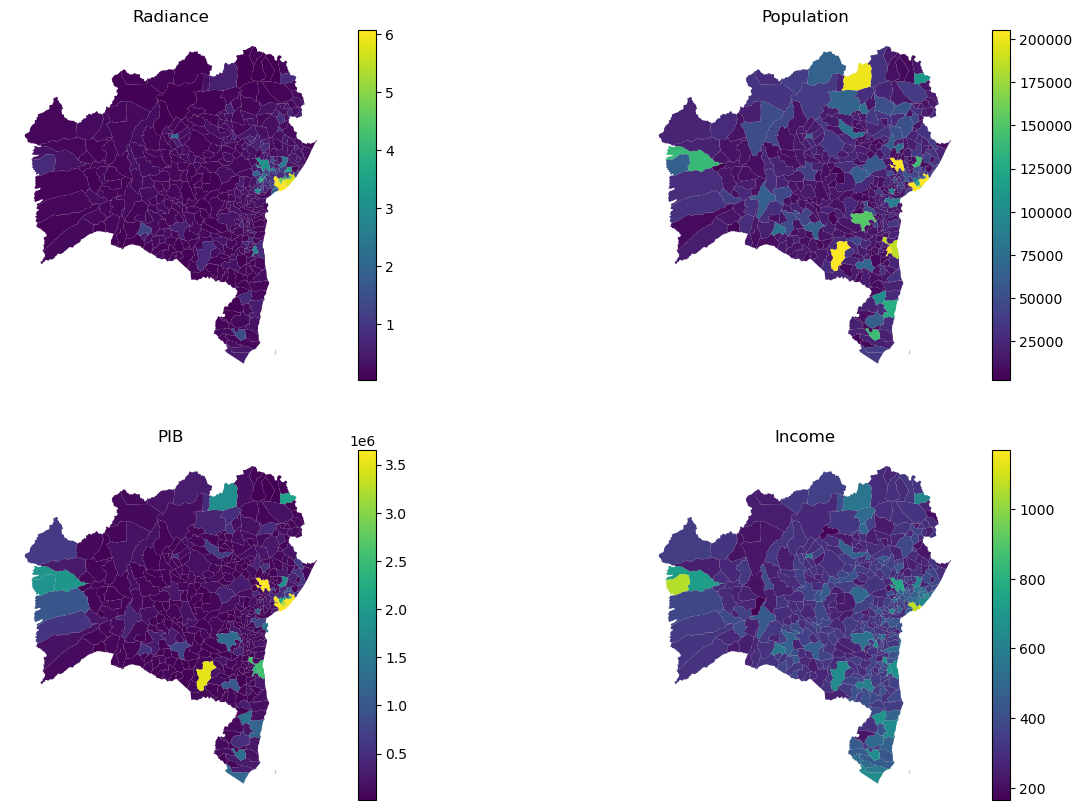

In [59]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

radiance = axs[0][0]
population = axs[0][1]
pib = axs[1][0]
income = axs[1][1]

merged.plot(column='w_radiance', cmap='viridis', linewidth=0.01, ax=radiance, edgecolor='0.1', legend = True)
radiance.title.set_text('Radiance')
radiance.set_axis_off()

merged.plot(column='w_population', cmap='viridis', linewidth=0.01, ax=population, edgecolor='0.1', legend = True)
population.title.set_text('Population')
population.set_axis_off()

merged.plot(column='w_pib', cmap='viridis', linewidth=0.01, ax=pib, edgecolor='0.1', legend = True)
pib.title.set_text('PIB')
pib.set_axis_off()

merged.plot(column='income', cmap='viridis', linewidth=0.01, ax=income, edgecolor='0.1', legend = True)
income.title.set_text('Income')
income.set_axis_off()